<a href="https://colab.research.google.com/github/Bhamini12/TM/blob/main/AI_IS_SLR_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# If running on Colab, uncomment the next lines if any library is missing
# !pip install numpy pandas matplotlib scikit-learn nltk networkx==3.2.1 python-louvain==0.16

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import networkx as nx
from collections import Counter
import nltk
import re
import math

# NLTK resources (safe to re-run)
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
from nltk.corpus import stopwords

# Matplotlib settings (use defaults; do not set styles or colors)
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import pandas as pd

data_path = "ai_is_slr_dataset.csv"  # If you upload to Colab, put the same filename in /content
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    # Fallback for Colab: ask user to upload
    from google.colab import files
    uploaded = files.upload()  # user can upload both the example CSV or a real export
    df = pd.read_csv(list(uploaded.keys())[0])

df.head(3)

,title,authors,abstract,keywords,venue,year
0,Artificial Intelligence in Management Informat...,John Smith; Alice Brown,This paper explores how artificial intelligenc...,"AI, MIS, Decision Making",MIS Quarterly,2020
1,Machine Learning for Decision Support in IS,Ravi Kumar; Li Chen,Machine learning models are tested in decision...,"Machine Learning, IS, Decision Support",Information Systems Research,2020
2,Neural Networks for IT Service Optimization,Maria Lopez; Hans Becker,Neural networks are applied to improve IT serv...,"Neural Networks, IT, Optimization",Journal of IT,2020


In [5]:
# Show a few random rows to understand the schema
df.sample(5, random_state=42)

,title,authors,abstract,keywords,venue,year
8,Augmented Decision Making with AI,Emily Davis; Robert King,AI-based systems are applied for augmenting hu...,"AI, Decision Making, Augmentation",MIS Quarterly,2020
1,Machine Learning for Decision Support in IS,Ravi Kumar; Li Chen,Machine learning models are tested in decision...,"Machine Learning, IS, Decision Support",Information Systems Research,2020
5,The Role of AI in Strategic Information Systems,Priya Gupta; Michael Ross,Explores the role of AI technologies in shapin...,"AI, Strategic IS, Management",Journal of Strategic Information Systems,2020
0,Artificial Intelligence in Management Informat...,John Smith; Alice Brown,This paper explores how artificial intelligenc...,"AI, MIS, Decision Making",MIS Quarterly,2020
7,AI and Robotics for Enterprise IS,Ahmed Khan; Sofia Torres,Investigates AI and robotics applications for ...,"AI, Robotics, Enterprise IS",Journal of the Association for Information Sys...,2020


In [6]:
# Basic cleaning
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['title', 'abstract']).copy()

# Deduplicate on title+year (heuristic; refine with DOI in real data)
df['title_key'] = df['title'].str.lower().str.replace(r'\W+', ' ', regex=True).str.strip()
before = len(df)
df = df.drop_duplicates(subset=['title_key', 'year'])
after = len(df)
print(f'Removed {before - after} potential duplicates; remaining: {after}')

# Light text cleaning
def clean_text(s):
    s = re.sub(r'\s+', ' ', str(s))
    return s.strip()

for col in ['title', 'abstract', 'venue', 'authors', 'keywords']:
    if col in df.columns:
        df[col] = df[col].fillna('').map(clean_text)

df.head(2)

Removed 0 potential duplicates; remaining: 10


,title,authors,abstract,keywords,venue,year,title_key
0,Artificial Intelligence in Management Informat...,John Smith; Alice Brown,This paper explores how artificial intelligenc...,"AI, MIS, Decision Making",MIS Quarterly,2020,artificial intelligence in management informat...
1,Machine Learning for Decision Support in IS,Ravi Kumar; Li Chen,Machine learning models are tested in decision...,"Machine Learning, IS, Decision Support",Information Systems Research,2020,machine learning for decision support in is


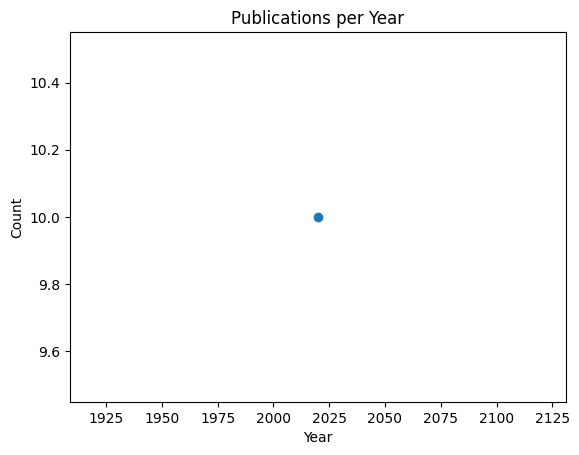

,year,n
0,2020,10


In [7]:
# Publications per year
counts = df.groupby('year').size().reset_index(name='n')
counts = counts.sort_values('year')
plt.figure()
plt.plot(counts['year'], counts['n'], marker='o')
plt.title('Publications per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()
counts.tail(10)

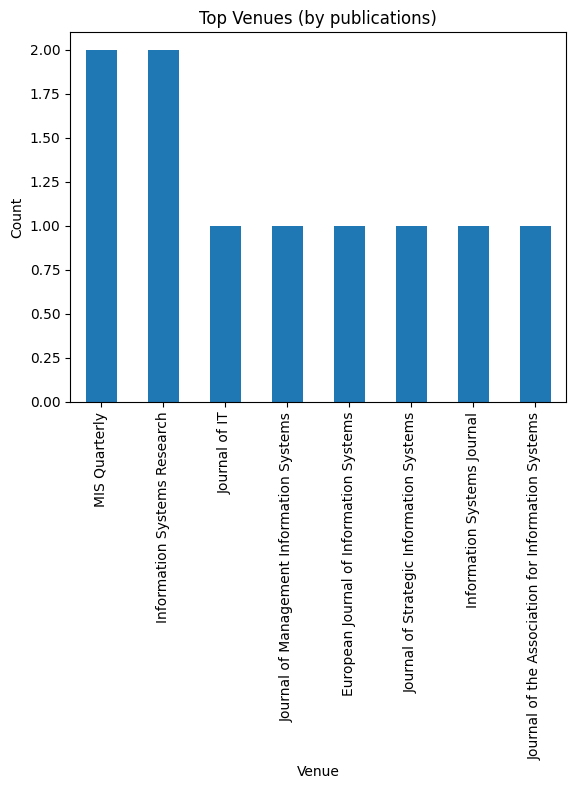

,count
venue,
MIS Quarterly,2
Information Systems Research,2
Journal of IT,1
Journal of Management Information Systems,1
European Journal of Information Systems,1
Journal of Strategic Information Systems,1
Information Systems Journal,1
Journal of the Association for Information Systems,1


In [8]:
# Top venues by count
top_venues = df['venue'].value_counts().head(10)
plt.figure()
top_venues.plot(kind='bar')
plt.title('Top Venues (by publications)')
plt.xlabel('Venue')
plt.ylabel('Count')
plt.show()
top_venues


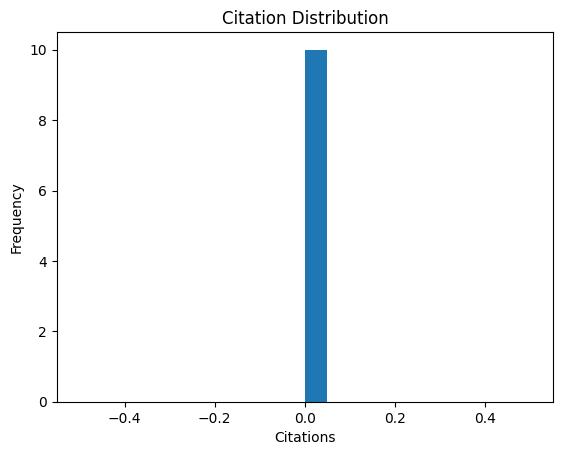

,citations
count,10.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [9]:
# Citation distribution overview
if 'citations' in df.columns:
    df['citations'] = pd.to_numeric(df['citations'], errors='coerce').astype(int)
else:
    df['citations'] = 0 # Default to 0 if column doesn't exist

plt.figure()
df['citations'].plot(kind='hist', bins=20)
plt.title('Citation Distribution')
plt.xlabel('Citations')
plt.ylabel('Frequency')
plt.show()

display(df[['citations']].describe())

In [10]:
# Normalize keywords: lowercase, strip, unify synonyms (example map)
syn_map = {
    'ai': 'artificial intelligence',
    'xai': 'explainable ai',
    'natural language processing': 'NLP',
    'nlp': 'NLP',
    'computer-vision': 'computer vision',
    'it governance': 'governance',
}
def normalize_kw(s):
    parts = [p.strip().lower() for p in str(s).split(';') if p.strip()]
    out = []
    for p in parts:
        p = p.replace('-', ' ')
        p = syn_map.get(p, p)
        out.append(p)
    # remove duplicates while preserving order
    seen = set()
    uniq = []
    for k in out:
        if k not in seen:
            uniq.append(k)
            seen.add(k)
    return uniq

df['kw_list'] = df['keywords'].apply(normalize_kw)

# Build co-occurrence matrix
from itertools import combinations
pair_counter = Counter()
for kws in df['kw_list']:
    for a, b in combinations(sorted(set(kws)), 2):
        pair_counter[(a, b)] += 1

# Create graph
G = nx.Graph()
for (a, b), w in pair_counter.items():
    if w >= 2:  # simple threshold
        G.add_edge(a, b, weight=int(w))

print(f'Keyword nodes: {G.number_of_nodes()}, edges (>=2 co-occ): {G.number_of_edges()}')

# Simple centrality & top keywords
deg = dict(G.degree())
top_nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:15]
pd.DataFrame(top_nodes, columns=['keyword', 'degree'])

Keyword nodes: 0, edges (>=2 co-occ): 0


,keyword,degree


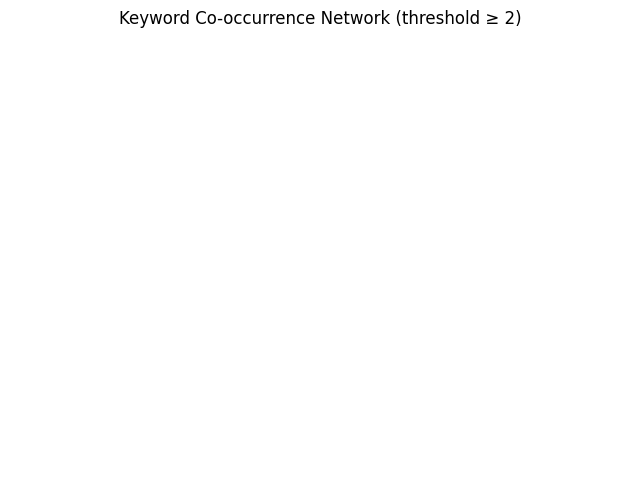

In [11]:
# Plot the keyword co-occurrence network (basic)
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=80)
nx.draw_networkx_edges(G, pos, alpha=0.4)
# Label only the most connected nodes for readability
deg = dict(G.degree())
labels = {k: k for k, v in deg.items() if v >= max(deg.values()) - 2}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
plt.title('Keyword Co-occurrence Network (threshold ≥ 2)')
plt.axis('off')
plt.show()


In [12]:
# Prepare text
stop = set(stopwords.words('english'))
def preprocess_text(s):
    s = s.lower()
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    toks = [t for t in s.split() if t not in stop and len(t) > 2]
    return ' '.join(toks)

df['abs_clean'] = df['abstract'].map(preprocess_text)

# Vectorize
tfidf = TfidfVectorizer(max_df=0.8, min_df=3, max_features=3000)
X = tfidf.fit_transform(df['abs_clean'])

# LDA (on term counts better; using tfidf is acceptable for demo)
count_vec = CountVectorizer(max_df=0.8, min_df=3, max_features=3000)
X_count = count_vec.fit_transform(df['abs_clean'])

n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch', max_iter=20)
lda.fit(X_count)

terms = np.array(count_vec.get_feature_names_out())
def show_topics(model, terms, topn=12):
    topic_words = {}
    for idx, comp in enumerate(model.components_):
        top_ids = comp.argsort()[-topn:][::-1]
        topic_words[idx] = terms[top_ids].tolist()
    return topic_words

topic_words = show_topics(lda, terms, topn=12)
pd.DataFrame.from_dict(topic_words, orient='index')

,0,1,2,3
0,systems,information,applied,decision
1,decision,applied,systems,information
2,systems,information,applied,decision
3,information,systems,applied,decision
4,information,systems,decision,applied
5,applied,systems,information,decision


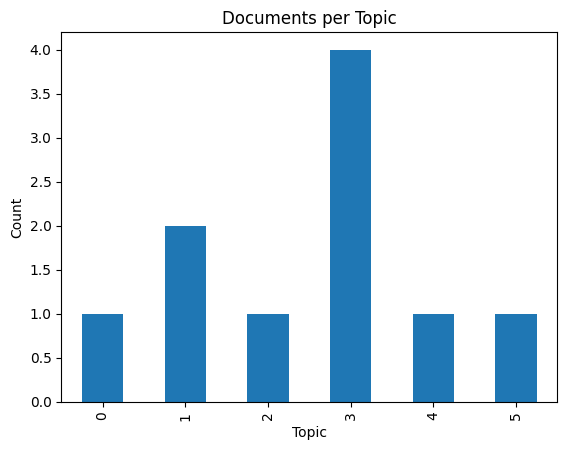

,count
dominant_topic,
0,1
1,2
2,1
3,4
4,1
5,1


In [13]:
# Assign dominant topic to each document
doc_topic = lda.transform(count_vec.transform(df['abs_clean']))
df['dominant_topic'] = doc_topic.argmax(axis=1)
topic_counts = df['dominant_topic'].value_counts().sort_index()
plt.figure()
topic_counts.plot(kind='bar')
plt.title('Documents per Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

topic_counts

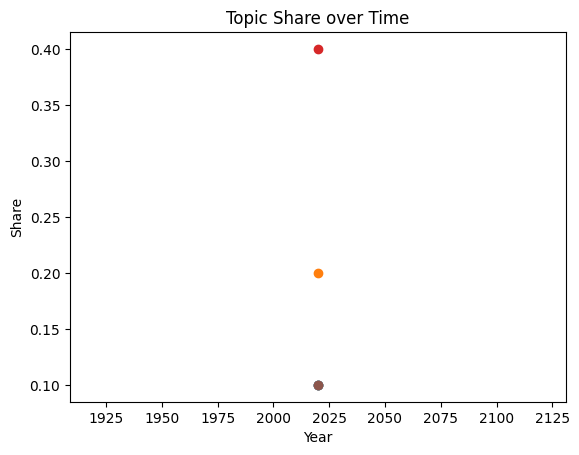

dominant_topic,0,1,2,3,4,5
year,,,,,,
2020,0.1,0.2,0.1,0.4,0.1,0.1


In [14]:
# Topic share by year
topic_by_year = df.groupby(['year', 'dominant_topic']).size().reset_index(name='n')
total_by_year = df.groupby('year').size().reset_index(name='tot')
topic_by_year = topic_by_year.merge(total_by_year, on='year')
topic_by_year['share'] = topic_by_year['n'] / topic_by_year['tot']

pivot = topic_by_year.pivot(index='year', columns='dominant_topic', values='share').fillna(0)
plt.figure()
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker='o')
plt.title('Topic Share over Time')
plt.xlabel('Year')
plt.ylabel('Share')
plt.show()

pivot.tail(10)

In [15]:
# Parse authors; build co-authorship network
def split_authors(s):
    return [a.strip() for a in str(s).split(';') if a.strip()]

df['auth_list'] = df['authors'].map(split_authors)

pair_counter = Counter()
for auths in df['auth_list']:
    auths = sorted(set(auths))
    for i in range(len(auths)):
        for j in range(i+1, len(auths)):
            pair_counter[(auths[i], auths[j])] += 1

G_auth = nx.Graph()
for (a, b), w in pair_counter.items():
    if w >= 2:
        G_auth.add_edge(a, b, weight=int(w))

print(f'Authors: {G_auth.number_of_nodes()}, Collaborations (>=2): {G_auth.number_of_edges()}')

# Degree centrality
deg = dict(G_auth.degree())
top_auth = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:15]
pd.DataFrame(top_auth, columns=['author', 'degree'])

Authors: 0, Collaborations (>=2): 0


,author,degree


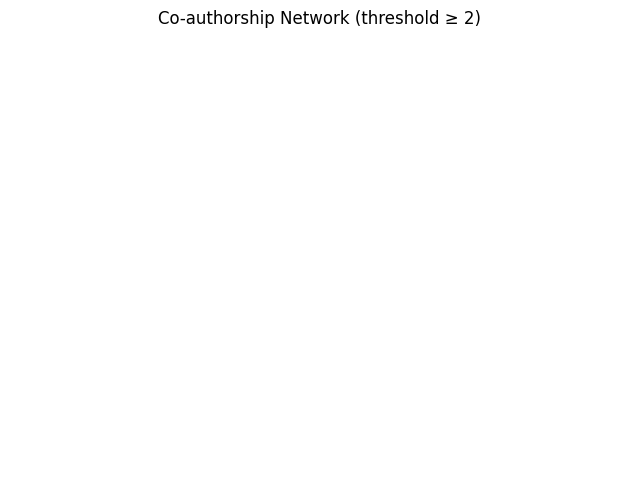

In [16]:
# Plot co-authorship network (sparse view)
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_auth, seed=42)
nx.draw_networkx_nodes(G_auth, pos, node_size=80)
nx.draw_networkx_edges(G_auth, pos, alpha=0.4)
labels = {k: k for k, v in dict(G_auth.degree()).items() if v >= 3}
nx.draw_networkx_labels(G_auth, pos, labels=labels, font_size=8)
plt.title('Co-authorship Network (threshold ≥ 2)')
plt.axis('off')
plt.show()


## 9. From findings to a **Research Agenda** (template)

Use the outputs above to identify gaps. Fill this table based on your observations.


In [17]:
from textwrap import dedent
agenda = dedent('''
Theme | What we know | Gaps | Why it matters | Suggested RQs | Methods | Data
----- | ------------- | ---- | -------------- | ------------- | ------ | ----
Explainable AI in IS | Many works discuss trust | Limited field evidence in high-stakes IS | Impacts adoption & compliance | RQ1: How does XAI affect IS decision quality? | Field experiments | Enterprise logs + surveys
AI Governance | Frameworks proposed | Few comparative studies across industries | Guides responsible AI in IS | RQ2: Which governance mechanisms reduce bias incidents? | Comparative case studies | Audit logs, incident reports
AIOps/MLOps in IS | Tooling described | ROI and socio-technical impacts underexplored | Links model lifecycle to IS value | RQ3: How do MLOps practices affect outage rates? | Longitudinal studies | Observability + ticket data
Human-AI Collaboration | UI patterns emerging | Little on boundary conditions | Prevents over/under‑reliance | RQ4: What levels of autonomy fit which IS tasks? | Mixed methods | Usage telemetry + interviews
''').strip()
print(agenda)

Theme | What we know | Gaps | Why it matters | Suggested RQs | Methods | Data
----- | ------------- | ---- | -------------- | ------------- | ------ | ----
Explainable AI in IS | Many works discuss trust | Limited field evidence in high-stakes IS | Impacts adoption & compliance | RQ1: How does XAI affect IS decision quality? | Field experiments | Enterprise logs + surveys
AI Governance | Frameworks proposed | Few comparative studies across industries | Guides responsible AI in IS | RQ2: Which governance mechanisms reduce bias incidents? | Comparative case studies | Audit logs, incident reports
AIOps/MLOps in IS | Tooling described | ROI and socio-technical impacts underexplored | Links model lifecycle to IS value | RQ3: How do MLOps practices affect outage rates? | Longitudinal studies | Observability + ticket data
Human-AI Collaboration | UI patterns emerging | Little on boundary conditions | Prevents over/under‑reliance | RQ4: What levels of autonomy fit which IS tasks? | Mixed metho

Exported clean_ai_is_records.csv, topic_counts.csv, publications_per_year.png


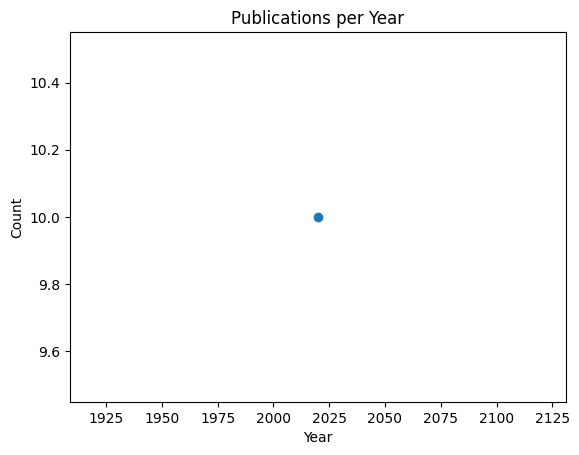

In [18]:
# Example exports
df.to_csv('clean_ai_is_records.csv', index=False)
topic_counts.to_csv('topic_counts.csv')

# Save the latest figure as an image (re-run a plot cell before this if needed)
plt.figure()
counts = df.groupby('year').size()
counts.plot(kind='line', marker='o')
plt.title('Publications per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.savefig('publications_per_year.png', bbox_inches='tight')
print('Exported clean_ai_is_records.csv, topic_counts.csv, publications_per_year.png')
